# CORD-19 citation network analysis

In this notebook, we build a bibliographic coupling citation network of the publications we could match in Dimensions, and perform clustering using the Leiden algorithm. We export cluster partition information, as well as global and local (cluster-specific) centrality measures to use in the regression analysis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, time, pickle
import ujson as json
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
# dataset Dimensions: source of citation data

json_sources = "../cwts_covid/datasets_output/json_dimensions_cwts"

In [3]:
# build networks and node metadata
# this requires Dimensions data, downloaded following: https://github.com/CWTSLeiden/cwts_covid

from collections import OrderedDict
import sys

metadata = list()
metadata_dict = dict()
citations = OrderedDict()
total_publications = 0

for root, dirs, files in os.walk(json_sources):
    for f in files:
        all_data = codecs.open(os.path.join(root,f)).read()
        for line in all_data.split("\n"):
            total_publications += 1
            if line:
                try:
                    data = json.loads(line)
                    if "references" in data.keys() and len(data["references"])>0: # filter out papers without outbound citations
                        title = ""
                        year = ""
                        doi = ""
                        pmid = ""
                        d_id = ""
                        times_cited = ""
                        journal = ""
                        if "title" in data.keys() and data["title"]:
                            title = data["title"].replace('"',"")
                        if "journal" in data.keys() and "title" in data["journal"].keys() and data["journal"]["title"]:
                            jorunal = data["journal"]["title"]
                        if "year" in data.keys() and data["year"]:
                            year = str(data["year"])
                        if "doi" in data.keys() and data["doi"]:
                            doi = data["doi"]
                        if "pmid" in data.keys() and data["pmid"]:
                            doi = str(data["pmid"])
                        if "id" in data.keys() and data["id"]:
                            d_id = str(data["id"])
                        if "times_cited" in data.keys():
                            times_cited = str(data["times_cited"])
                        metadata.append((d_id,'"'+title+'"',year,'"'+doi+'"',pmid,'"'+journal+'"',times_cited))
                        metadata_dict[d_id] = {"title":title,"year":year,"doi":doi,"journal":journal,"times_cited":times_cited,
                                                    "pmid":pmid,"d_id":d_id}
                        citations[data["id"]] = data["references"]
                except ValueError:
                    print("Could not convert data.")
                except:
                    print(line)
                    continue

In [4]:
len(citations)

54293

In [5]:
total_publications

68309

In [6]:
# create bibc network
# this is a super naive method, and takes a while

bibc_edge_list = list()
items = [(k,v) for k,v in citations.items()]

for n,(k1,v1) in tqdm(enumerate(items)):
    for k2,v2 in items[n+1:]:
        edge_weight = len(set(v2).intersection(set(v1))) / len(set(v2).union(set(v1))) # fractional edge weight
        if edge_weight > 0:
            bibc_edge_list.append((k1,k2,str(edge_weight)))

In [7]:
# export in csv (optional)

with open("data/bib_coupling_edgelist_norm.csv","w") as f:
    f.write("Source,Target,Weight\n")
    for edge in bibc_edge_list:
        #if float(edge[2])>1:
        f.write(",".join(edge)+"\n")

In [8]:
with open("data/bib_coupling_nodelist.csv","w") as f:
    f.write("ID,Title,Year,DOI,PMID,Journal,Times_cited\n")
    for node in metadata:
        f.write(",".join(node)+"\n")

In [9]:
len(bibc_edge_list)

21078418

In [10]:
weight_list = [float(x[2]) for x in bibc_edge_list if float(x[2])>0]

In [11]:
np.median(weight_list)

0.015625

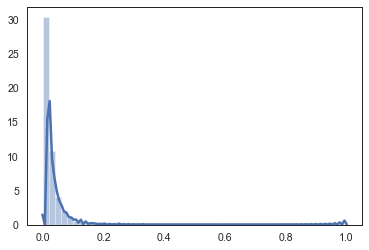

In [12]:
sns.distplot(weight_list)

In [13]:
# create an igraph graph

import igraph as ig
ig.set_random_number_generator(random.seed(seed))

In [14]:
g = ig.Graph(directed=False)

In [15]:
edges = [(int(k[0].replace("pub.","")),int(k[1].replace("pub.",""))) for k in bibc_edge_list]
nodes = list(set([k[0] for k in edges]).union(set([k[1] for k in edges])))
weights = [float(k[2]) for k in bibc_edge_list]

In [16]:
# mapping of nodes to identifiers

node_map = {k:n for n,k in enumerate(nodes)}
edges_int = [(node_map[k[0]],node_map[k[1]]) for k in edges]
nodes_int = [node_map[k] for k in nodes]

In [17]:
len(node_map)

53252

In [18]:
"There are "+str(len(citations)-len(node_map))+" disconnected publications (with references)"

'There are 1041 disconnected publications (with references)'

In [19]:
inverse_node_map = {n:k for k,n in node_map.items()}

In [20]:
# add nodes and edges

g.add_vertices(nodes_int)
g.add_edges(edges_int)
g.es["weight"] = weights
g.vs["weight"] = 1
g.vs["dimensions_id"] = nodes

In [21]:
# clustering 
import leidenalg as la

In [22]:
h = g.components(mode='weak').giant()

In [23]:
len(h.vs)

53131

In [24]:
# 0.05 seems to find a relatively high modularity and reasonable sized clusters. Lowering it brings up one or two large clusters.

partition = la.find_partition(h, la.CPMVertexPartition, resolution_parameter = 0.05)

In [25]:
partition.quality()

21566583.499999005

In [26]:
partition.q

0.3886989085767341

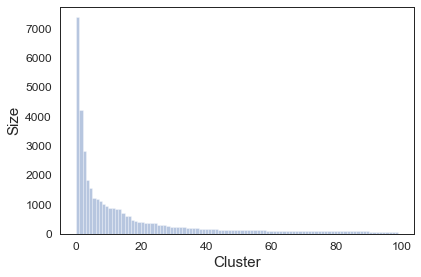

In [27]:
# distribution of the size of clusters

b = sns.distplot([x for x in partition.membership if x<100], norm_hist=False, kde=False, bins=100)
b.set_xlabel("Cluster",fontsize=15)
b.set_ylabel("Size",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb4_cluster_size_distr.pdf")

In [28]:
from collections import Counter

c = Counter(partition.membership)

In [29]:
len(c)

2296

In [167]:
c.most_common(15)

[(0, 7371),
 (1, 4208),
 (2, 2805),
 (3, 1831),
 (4, 1558),
 (5, 1202),
 (6, 1179),
 (7, 1125),
 (8, 1003),
 (9, 950),
 (10, 869),
 (11, 861),
 (12, 846),
 (13, 828),
 (14, 701)]

In [31]:
cluster_sizes = {c:s for c,s in c.most_common()}

In [32]:
# add note attributes and calculate indicators. This takes some time to compute

In [33]:
h.vs['cluster_id'] = partition.membership
h.vs['cluster_above_threshold'] = False
h.vs['cluster_size'] = [cluster_sizes[x] for x in partition.membership]

In [34]:
h.vs['global_degree'] = h.degree()

In [35]:
h.vs['global_pagerank'] = h.pagerank(directed=False, weights='weight')

In [36]:
# using a cutoff here
#h.vs['global_closeness'] = h.closeness(weights='weight')

In [37]:
# cluster-specific indicators
h.vs['local_degree'] = np.nan
h.vs['local_pagerank'] = np.nan
#h.vs['local_closeness'] = np.nan

In [57]:
threshold = 800 # we only calculate indicators for nodes in clusters of size equal of greater than this threshold

# we pick a treshold to consider > 50% of the nodes
sum([x[1] for x in c.most_common() if x[1]>=threshold])/len(h.vs)

0.5013269089608703

In [58]:
for cluster in c.most_common():
    c_id = cluster[0]
    c_size = cluster[1]
    if c_size >= threshold:
        t = partition.subgraph(c_id)
        t.vs['local_degree'] = t.degree()
        t.vs['local_pagerank'] = t.pagerank(directed=False, weights='weight')
        for v in t.vs:
            h.vs.find(dimensions_id=v['dimensions_id'])['local_degree'] = v['local_degree']
            h.vs.find(dimensions_id=v['dimensions_id'])['local_pagerank'] = v['local_pagerank']
            h.vs.find(dimensions_id=v['dimensions_id'])['cluster_above_threshold'] = True

In [60]:
# create and export a data frame
df_network = pd.DataFrame.from_dict({"dimensions_id": ["pub."+str(i) for i in h.vs['dimensions_id']],
                                     "network_cluster_id": h.vs['cluster_id'],
                                     "network_cluster_above_threshold": h.vs['cluster_above_threshold'],
                                     "network_cluster_size": h.vs['cluster_size'],
                                     "network_global_degree": h.vs['global_degree'],
                                     "network_global_pagerank": h.vs['global_pagerank'],
                                     "network_local_degree": h.vs['local_degree'],
                                     "network_local_pagerank": h.vs['local_pagerank']})
df_network.to_csv("data/df_network.csv", index=False, compression="gzip")

In [61]:
# graph of clusters (optional)

H = partition.cluster_graph(combine_vertices={'weight': 'sum'},
                                                 combine_edges={'weight': 'mean'})
H.write("data/network_of_clusters.graphml",format="graphml")

### Plots

In [3]:
# you can select here if to use an LDA or a CTM topic model
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")
#df_topic_intensity = pd.read_csv("data/df_topic_intensity_ctm.csv", compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")
df_network = pd.read_csv("data/df_network.csv", compression="gzip")

In [4]:
df_topic_intensity.head()

,tm_coronaviruses,tm_transmission,tm_phe,tm_molecular_biology,tm_respiratory_diseases,tm_immunology,tm_clinical_medicine,pub_id
0,0.166054,0.000000,0.782990,0.000000,0.000000,0.043276,0.000000,0
1,0.381396,0.104781,0.114435,0.325978,0.000000,0.000000,0.000000,1
2,0.427406,0.000000,0.000000,0.000000,0.304966,0.000000,0.258405,2
3,0.639613,0.011437,0.000000,0.000000,0.202549,0.017787,0.126117,3
4,0.191039,0.000000,0.000000,0.145550,0.285993,0.000000,0.326059,4


In [5]:
df_topic_intensity.columns

Index(['tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine',
       'pub_id'],
      dtype='object')

In [6]:
topic_labels = ['tm_coronaviruses', 'tm_phe',
       'tm_transmission', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine']

In [7]:
tm_names = {"Coronaviruses": "tm_coronaviruses",
    "Public health and epidemics": "tm_phe",
    "Transmission": "tm_transmission",
    "Molecular biology": "tm_molecular_biology",
    "Respiratory diseases": "tm_respiratory_diseases",
    "Immunology": "tm_immunology",
    "Clinical medicine": "tm_clinical_medicine"}
topic_labels = [x for x in tm_names.keys()]
reverse_tm_names = {x:y for y,x in tm_names.items()}
df_topic_intensity.rename(columns=reverse_tm_names,inplace=True)

In [8]:
df_embeddings = df_network.merge(df_joined_all[["pub_id","dimensions_id","in_wikipedia","title","publication_year"]], how="inner", left_on="dimensions_id", right_on="dimensions_id")

In [9]:
df_embeddings.shape

(51324, 12)

In [10]:
df_embeddings = df_embeddings.merge(df_topic_intensity, how="inner", left_on="pub_id", right_on="pub_id")

In [11]:
df_topic_intensity.shape

(66915, 8)

In [12]:
df_embeddings.shape

(50174, 19)

In [13]:
df_embeddings.head()

,dimensions_id,network_cluster_id,network_cluster_above_threshold,network_cluster_size,network_global_degree,network_global_pagerank,network_local_degree,network_local_pagerank,pub_id,in_wikipedia,title,publication_year,Coronaviruses,Transmission,Public health and epidemics,Molecular biology,Respiratory diseases,Immunology,Clinical medicine
0,pub.1103626240,18,False,412,264,0.000009,NaN,NaN,31796,False,Molecularly specific detection of bacterial li...,2018.0,0.094277,0.010803,0.054898,0.279896,0.067304,0.323404,0.167419
1,pub.1121976320,174,False,28,34,0.000006,NaN,NaN,60836,False,An Exploration of Machine Learning Methods for...,2019.0,0.021636,0.000000,0.581015,0.000000,0.000000,0.124919,0.267546
2,pub.1038352402,6,True,1179,583,0.000013,296.0,0.000626,46876,False,Smallpox and Season: Reanalysis of Historical ...,2009.0,0.210432,0.000000,0.632429,0.000000,0.000000,0.000000,0.149465
3,pub.1026031634,2,True,2805,686,0.000019,488.0,0.000373,52694,False,Clinical Presentation and Birth Outcomes Assoc...,2016.0,0.286207,0.000000,0.000000,0.000000,0.261411,0.025059,0.423279
4,pub.1032847387,52,False,118,109,0.000007,NaN,NaN,41213,False,CD4(+) T cells against human papillomavirus-18...,2010.0,0.038589,0.185210,0.000000,0.473719,0.033090,0.047457,0.218224


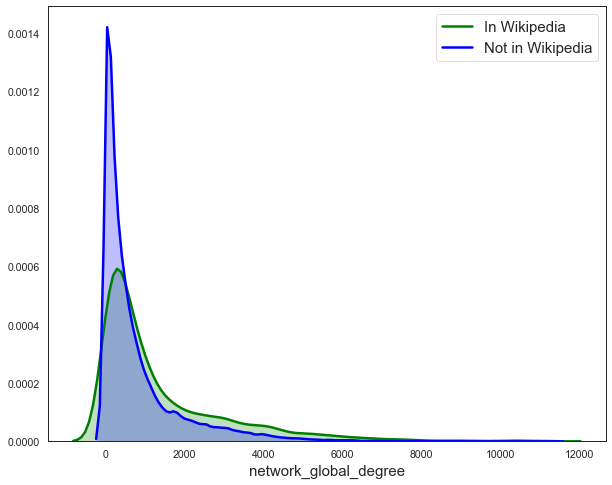

In [14]:
# distribution of centralities for papers cited from Wikipedia or not

which_centrality = "network_global_degree"

plt.figure(figsize=(10,8))
sns.distplot(df_embeddings[df_embeddings.in_wikipedia==True][which_centrality].values, color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(df_embeddings[df_embeddings.in_wikipedia==False][which_centrality].values, color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("%s"%which_centrality,fontsize=15)
plt.savefig("figures/nb4_%s_in_wiki.pdf"%which_centrality)

In [15]:
# plot cluster % of papers cited from Wikipedia, against cluster size

In [18]:
threshold = 800 #see above

In [19]:
cluster_coverage = list()
cluster_size = list()
cluster_number = list()
below_threshold_size = 0
below_threshold_coverage = 0
local_threshold = threshold
#threshold = 500

# also calculate paper centralities wrt. cluster centroid
# for every paper, this is 1 - the (cosine) distance wrt. its centroid
# we need both similarity and args to index results

for cl in c.most_common():
    cl_size = cl[1]
    inw = df_embeddings[(df_embeddings.in_wikipedia==True)&(df_embeddings.network_cluster_id==cl[0])].shape[0]
    if cl[1]>=threshold:
        coverage = inw/cl_size
        cluster_coverage.append(coverage)
        cluster_size.append(cl_size)
        cluster_number.append(cl[0])
    else:
        below_threshold_coverage += inw
        below_threshold_size += cl_size
#cluster_coverage.append(below_threshold_coverage/below_threshold_size)
#cluster_size.append(below_threshold_size)
#cluster_number.append(-1)

NameError: name 'c' is not defined

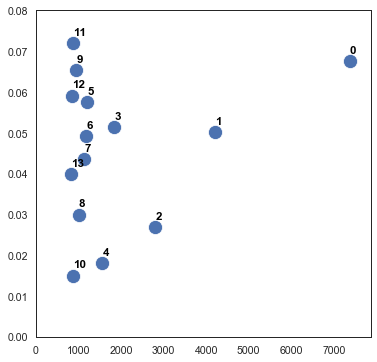

In [169]:
plt.figure(figsize=(6,6))
pl = sns.scatterplot(x=cluster_size,y=cluster_coverage,s=200)
# add annotations one by one with a loop
for dot in cluster_number:
     pl.text(cluster_size[dot]+7, cluster_coverage[dot]+0.002, s=cluster_number[dot], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim((0,0.08))
plt.xlim((0,max(cluster_size)+500))
#plt.legend(fontsize=15)
#plt.savefig("figures/nb4_cluster_size_vs_wiki_coverage_%d_no_max.pdf"%local_threshold)

In [20]:
which_cluster = 11

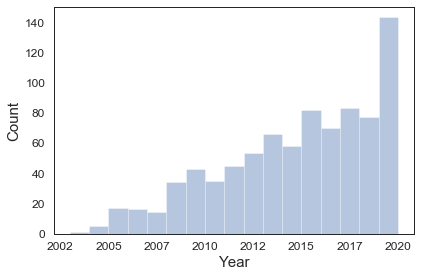

In [21]:
sns.distplot(df_embeddings[df_embeddings.network_cluster_id == which_cluster].publication_year, bins=17, kde=False)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
#plt.savefig("figures/nb4_cluster_%d_yeardistr.pdf"%(which_cluster))

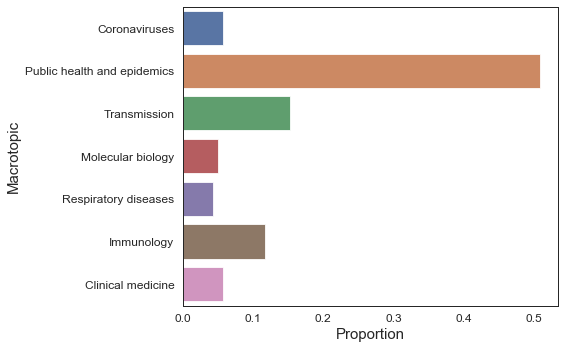

In [22]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings[df_embeddings.network_cluster_id == which_cluster][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig("figures/nb4_cluster_%d_to_topicmodel.pdf"%(which_cluster))

In [23]:
# examples of central papers in a cluster

df_embeddings[["dimensions_id","network_cluster_id","network_cluster_size","network_global_degree","network_global_pagerank","title","publication_year"]][df_embeddings.network_cluster_id==which_cluster].sort_values("network_global_pagerank",ascending=False).head(20)

,dimensions_id,network_cluster_id,network_cluster_size,network_global_degree,network_global_pagerank,title,publication_year
34468,pub.1078379372,11,861,1156,0.000047,Recent Trends in Emerging Infectious Diseases,2009.0
8494,pub.1039182086,11,861,1799,0.000045,Human viruses: discovery and emergence,2012.0
15474,pub.1000945380,11,861,1176,0.000043,Temporal trends in the discovery of human viruses,2008.0
28889,pub.1039290262,11,861,1116,0.000043,Emerging infectious diseases,2014.0
46141,pub.1038331952,11,861,1238,0.000042,Spillover and pandemic properties of zoonotic ...,2015.0
687,pub.1071123465,11,861,1911,0.000041,Assessing the Epidemic Potential of RNA and DN...,2016.0
34828,pub.1092537083,11,861,1488,0.000040,Stochastic dynamics of an epidemics with recur...,2017.0
30311,pub.1015443089,11,861,1138,0.000040,Global trends in emerging infectious diseases,2008.0
36983,pub.1121122319,11,861,1502,0.000040,Chapter 4 Human Viruses: Emergence and Evolution,2020.0
5450,pub.1060399641,11,861,2279,0.000040,Faecal virome of cats in an animal shelter,2014.0
